<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/DL_week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Вебинар 3:  Построение многослойных нейросетей и вычислительный граф

Рассмотрим многослойные нейросети, разберем вычислительный граф и реализуем сеть в PyTorch.


**Описание**: Изучим основные элементы архитектуры нейросетей, разберем функции активации и их влияние на обучение модели.

## 0.В прошлом вебинаре

### 1.Основные элементы нейросетей

**1. Нейроны (узлы):**

* *Входные нейроны:*  Получают данные из внешнего мира (например, пиксели изображения, значения датчиков).  Они не выполняют вычислений, а просто передают данные дальше.
* *Скрытые нейроны*:  Выполняют вычисления и передают результаты другим нейронам.  Организованы в слои.  Один скрытый слой - это набор нейронов, получающих входные данные от предыдущего слоя (или входного слоя) и передающих результаты следующему слою (или выходному слою).
* *Выходные нейроны:*  Производят окончательный результат работы сети (например, классификация объекта, предсказанное значение).

**2. Связи (синапсы) и веса:**

* *Связи:*  Соединяют нейроны между собой.  Каждый нейрон в слое связан со всеми нейронами в предыдущем и следующем слоях.
* *Веса:*  Числовые значения, связанные с каждой связью.  Они определяют силу влияния одного нейрона на другой.  Именно веса настраиваются в процессе обучения сети.

**3. Функция активации:**

* *Функция активации:*  Применяется к выходу каждого нейрона (кроме входных).  Она вносит нелинейность в модель, что позволяет сети обучаться сложным зависимостям в данных.  Примеры: sigmoid, ReLU, tanh, softmax.

**4. Архитектура сети:**

* *Количество слоев:*  Сети с одним скрытым слоем называются однослойными, с несколькими - многослойными (глубокими).

* *Тип слоев:* Различные типы слоев выполняют разные функции (например, сверточные слои для обработки изображений, рекуррентные слои для обработки последовательностей).

* *Связность:*  Определяет, как нейроны связаны между собой (например, полносвязные слои, где каждый нейрон связан со всеми нейронами в предыдущем слое).

### 1.1 Нейроны (узлы) и синапсы (веса)

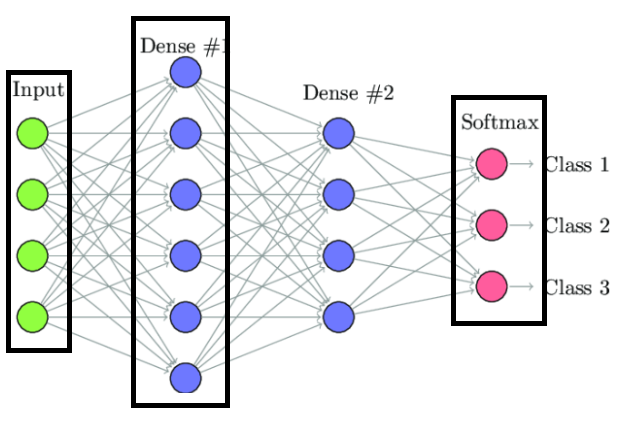

In [19]:
import torch
from torchsummary import summary

In [ ]:
# определяем девайс на котором будем создавать нашу нейронную сеть
device = 'cuda' if torch.device == 'cuda' else 'cpu'
print(device)

cpu


In [ ]:
class Feedforward(torch.nn.Module):
    """
    Простая полносвязная нейронная сеть (feedforward).

    Args:
        input_size (int): Размерность входного вектора.
        hidden_size (int): Размерность скрытого слоя.
    """
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()

        # Запоминаем размеры входного и скрытого слоев
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Первый полносвязный (линейный) слой
        # input_size -> hidden_size  без bias
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size,
                                   bias=True)

        # Функция активации ReLU
        self.relu = torch.nn.ReLU()

        # Второй полносвязный (линейный) слой
        # hidden_size -> 1  без bias
        self.fc2 = torch.nn.Linear(self.hidden_size, 1,
                                   bias=True)

        # Функция активации Sigmoid (для выходного слоя, подходит для бинарной классификации)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x):
        """
        Прямой проход данных через сеть.

        Args:
            x (torch.Tensor): Входной тензор.

        Returns:
            torch.Tensor: Выходной тензор.
        """
        # Вычисляем выход первого слоя
        hidden = self.fc1(x)

        # Применяем ReLU к выходу первого слоя
        relu = self.relu(hidden)

        # Вычисляем выход второго слоя
        output = self.fc2(relu)

        # Применяем Sigmoid к выходу второго слоя
        output = self.sigmoid(output)

        return output

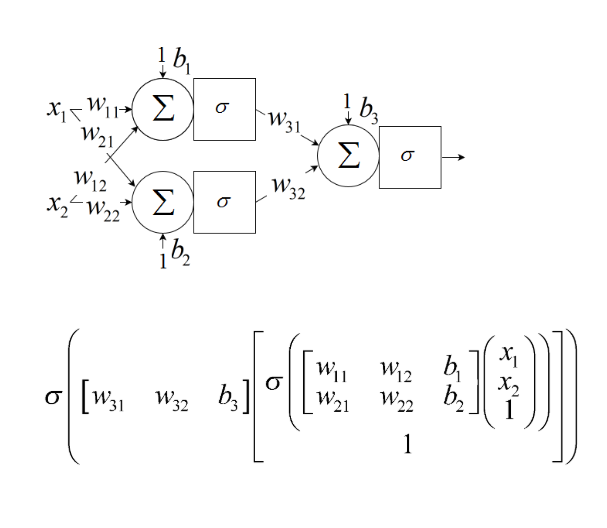

Определим следующие переменные:

* $\mathbf{x}$: входной вектор размерности input_size
* $\mathbf{W}_1$: матрица весов первого линейного слоя размерности hidden_size x input_size
* $\mathbf{h}$: выход первого линейного слоя (и вход ReLU) размерности hidden_size
* $\mathbf{r}$: выход ReLU (и вход второго линейного слоя) размерности hidden_size
* $\mathbf{W}_2$: матрица весов второго линейного слоя размерности 1 x hidden_size
* $o$: выход второго линейного слоя (и вход Sigmoid) размерности 1 (скаляр)
* $y$: выход Sigmoid (и сети в целом) размерности 1 (скаляр)


Формулы для вычислений в сети:

1. **Выход первого линейного слоя:**
   
   $$\mathbf{h} = \mathbf{W}_1 \mathbf{x}$$
   

2. **Выход ReLU:**
   
   $$\mathbf{r} = \max(0, \mathbf{h})$$
   
   Поэлементно:  $r_i = \max(0, h_i)$ для всех $i$ от 1 до hidden_size.

3. **Выход второго линейного слоя:**
   
   $$o = \mathbf{W}_2 \mathbf{r}$$
   

4. **Выход Sigmoid:**
   
   $$y = \frac{1}{1 + e^{-o}}$$
   

Таким образом, полная формула для вычисления выхода сети:

$$y = \frac{1}{1 + e^{-\mathbf{W}_2 \max(0, \mathbf{W}_1 \mathbf{x})}}$$


Важно отметить, что в данном коде bias не используется в линейных слоях. Если бы bias использовался, формулы 1 и 3 выглядели бы так:

1. $\mathbf{h} = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1$
3. $o = \mathbf{W}_2 \mathbf{r} + b_2$

где $\mathbf{b}_1$ и $b_2$ — векторы bias для первого и второго линейных слоев соответственно. В случае второго слоя $b_2$ — скаляр, так как выход слоя имеет размерность 1.

<font color='DarkOrange'>**Вопрос (?)**</font> Что является весами для этой модели?

In [ ]:
net = Feedforward(2, 3).to(device=device)
x = torch.tensor([1., 2.])
net(x)

tensor([0.4334], grad_fn=<SigmoidBackward0>)

In [ ]:
summary(net, (2,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
              ReLU-2                    [-1, 3]               0
            Linear-3                    [-1, 1]               4
           Sigmoid-4                    [-1, 1]               0
Total params: 13
Trainable params: 13
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


<font color='DarkOrange'>**Вопрос (?)**</font> Зачем нейронную сеть делать многослойной (в нашем случае двухслойной)?

<font color='DarkOrange'>**Вопрос (?)**</font> Зачем используется `ReLU` в данной нейронной сети?

__Теорема об универсальной аппроксимации__
[Hornik, 1991]

 *Любую непрерывную функцию можно с любой
точностью приблизить нейросетью глубины 2
с сигмоидной функцией активации на скрытом
слое и линейной функции на выходном слое*


Нейросеть глубины два с фиксированной функцией
активации в первом слое и линейной функцией активации
во втором может равномерно аппроксимировать (м.б.
при увеличении числа нейронов в первом слое) любую
непрерывную функцию на компактном множестве тогда
и только тогда, когда функция активации неполиномиальная.

Но есть нюансы...

- Много нейронов (неизвестно сколько)
- Экспоненциальные веса
- Сложность обучения

Модуль [`torch.nn`](https://pytorch.org/docs/stable/nn.html) содержит большое количество уже готовых слоев

Например, есть различные варианты [линейных слоев](https://pytorch.org/docs/stable/nn.html#linear-layers)

### 2.Функции активации

#### Технический код

In [ ]:
from torch import nn
import math

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

In [ ]:
set_matplotlib_formats("svg", "pdf")  # For export
sns.set()

<ipython-input-61-66ce23b69318>:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export


In [ ]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    # Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

In [ ]:
def get_grads(act_fn, x):
    """Computes the gradients of an activation function at specified positions.

    Args:
        act_fn: An object of the class "ActivationFunction" with an implemented forward pass.
        x: 1D input tensor.
    Returns:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_()  # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward()  # Summing results in an equal gradient flow to each element in x
    return x.grad  # Accessing the gradients of x by "x.grad"

In [ ]:
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]

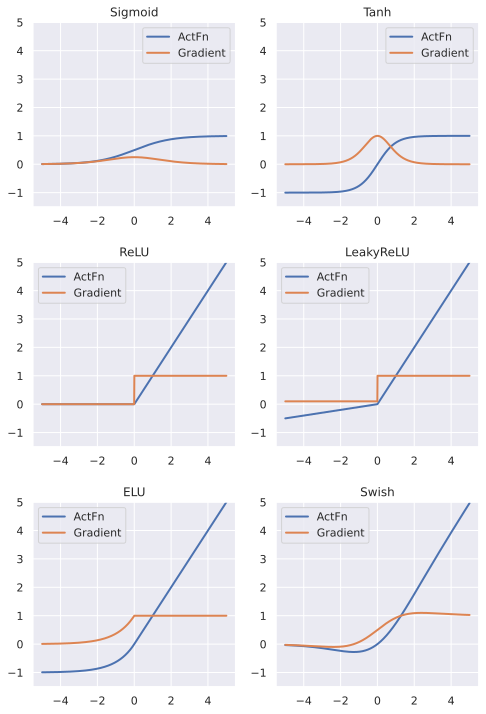

In [ ]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    # Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())


# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)  # Range on which we want to visualize the activation functions
# Plotting
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

#### 2.1Функции активации

In [ ]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [ ]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))


class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

In [ ]:
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()


class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)


class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)


class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

#### 2.2 Преимущества и недостатки функций активации

**1. Sigmoid:**

* **Формула:**  σ(x) = 1 / (1 + exp(-x))
* **Диапазон:** (0, 1)
* **Преимущества:**
    * Выходные значения интерпретируются как вероятности.
    * Гладкая функция, имеет производную везде.
* **Недостатки:**
    * **Затухающие градиенты:**  Производная близка к нулю при больших положительных или отрицательных значениях x, что затрудняет обучение глубоких сетей.
    * **Не центрирована в нуле:**  Выходные значения всегда положительны, что может замедлить обучение.
    * **Вычислительно затратна:**  Экспонента - относительно медленная операция.

**2. Tanh (гиперболический тангенс):**

* **Формула:** tanh(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
* **Диапазон:** (-1, 1)
* **Преимущества:**
    * **Центрирована в нуле:**  Улучшает сходимость обучения по сравнению с Sigmoid.
    * **Гладкая функция, имеет производную везде.**
* **Недостатки:**
    * **Затухающие градиенты:**  Хотя и меньше, чем у Sigmoid, проблема все еще присутствует.
    * **Вычислительно затратна.**

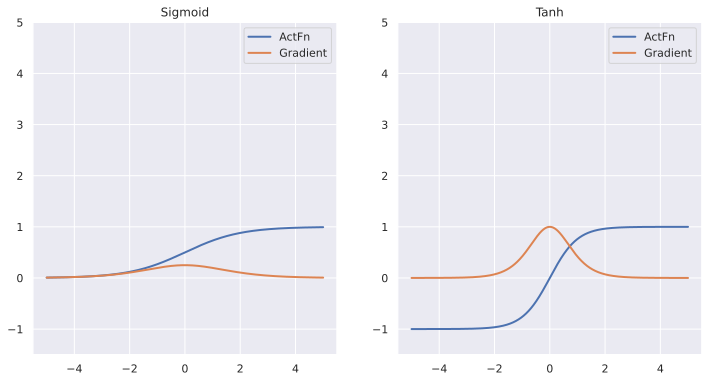

In [ ]:
# Plotting
cols = 2
rows = 1
fig, ax = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
for i, act_fn in enumerate(act_fns[:2]):
    vis_act_fn(act_fn, ax[i], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

##### <font color='DarkOrange'>**Вопрос (?)**</font> Что такое проблема затухающих градиентов?

##### <font color='DarkOrange'>**Ответ**</font>



__Проблема затухающих градиентов__ — одна из основных трудностей при обучении глубоких нейронных сетей.  Она возникает из-за способа, которым сети обучаются с использованием метода обратного распространения ошибки.

__Суть проблемы:__

В процессе обучения нейронной сети веса корректируются на основе __градиентов__ — производных функции потерь по отношению к весам.  
Эти градиенты вычисляются с помощью правила цепочки, начиная с выходного слоя и продвигаясь обратно к входному.

В глубоких сетях, особенно с использованием некоторых функций активации (таких как сигмоида или, в меньшей степени, гиперболический тангенс), градиенты могут становиться экспоненциально малыми по мере продвижения к начальным слоям.  Это происходит потому, что производные этих функций активации меньше единицы в большей части их диапазона.  При умножении многих таких малых значений (по правилу цепочки) результирующий градиент становится очень близким к нулю.


__Последствия затухающих градиентов:__

* __Медленное обучение:__  Малые градиенты приводят к незначительным изменениям весов в начальных слоях, что замедляет процесс обучения, особенно в глубоких сетях.
* __Застревание в локальных минимумах:__  Сеть может застрять в локальном минимуме функции потерь, так как начальные слои не получают достаточной информации для эффективного обучения.
* __Неспособность обучаться сложным зависимостям:__  Начальные слои сети отвечают за извлечение низкоуровневых признаков, которые важны для понимания сложных зависимостей в данных.  Если эти слои не обучаются должным образом, сеть не сможет эффективно обрабатывать сложную информацию.

__Решения проблемы затухающих градиентов:__

* Использование других функций активации:  ReLU (Rectified Linear Unit) и ее варианты (LeakyReLU, ELU, Swish) не страдают от затухающих градиентов в той же степени, что и сигмоида и tanh, так как их производная равна 1 для положительных значений входа.
* Инициализация весов (Xavier/Glorot, He):  Специальные методы инициализации весов помогают смягчить проблему затухающих градиентов.
* Нормализация по батчам (Batch Normalization):  Нормализует активации внутри мини-батча, что стабилизирует обучение и уменьшает влияние затухающих градиентов.
* Архитектуры с остаточными соединениями (ResNets):  Остаточные соединения позволяют градиентам "протекать" через сеть, минуя некоторые слои, что уменьшает вероятность их затухания.
* Градиентное отсечение (Gradient Clipping):  Ограничивает максимальное значение градиента, предотвращая его взрывной рост (который может быть обратной стороной затухающих градиентов в некоторых случаях).

####**3. ReLU (Rectified Linear Unit):**

* **Формула:** f(x) = max(0, x)
* **Диапазон:** [0, ∞)
* **Преимущества:**
    * **Решение проблемы затухающих градиентов** (для положительных значений x).
    * **Вычислительно эффективна:**  Простая операция сравнения.
    * **Ускоряет обучение:**  Благодаря отсутствию затухающих градиентов (для положительных x).
* **Недостатки:**
    * **"Умирающие нейроны":**  Нейроны могут "умереть" (всегда выводить ноль), если входные веса обновляются таким образом, что взвешенная сумма входов становится отрицательной.  Это особенно проблематично при больших темпах обучения.
    * **Не центрирована в нуле.**


**4. LeakyReLU:**

* **Формула:** f(x) = max(αx, x), где α - небольшое положительное число (например, 0.01).
* **Диапазон:** (-∞, ∞)
* **Преимущества:**
    * **Решение проблемы "умирающих нейронов" ReLU.**  Небольшое отрицательное значение позволяет градиентам продолжать распространяться даже при отрицательных x.
    * **Вычислительно эффективна.**
* **Недостатки:**
    * **α - гиперпараметр, который нужно подбирать.**
    * **Не центрирована в нуле.**

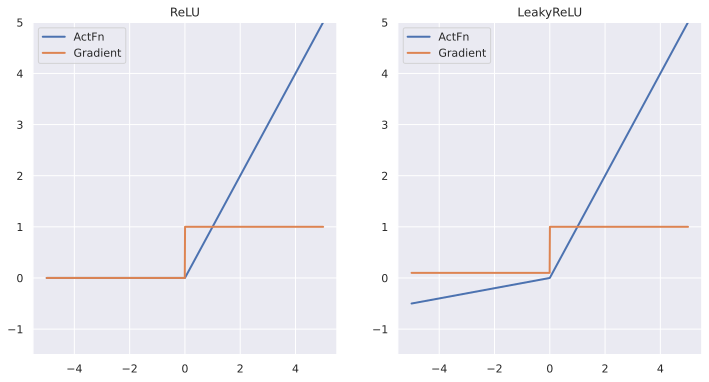

In [ ]:
# Plotting
cols = 2
rows = 1
fig, ax = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
for i, act_fn in enumerate(act_fns[2:4]):
    vis_act_fn(act_fn, ax[i], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

##### <font color='DarkOrange'>**Вопрос (?)**</font> Что такое проблема "умирающих" нейронов?

##### <font color='DarkOrange'>**Ответ**</font>

__Проблема умирающих нейронов (dying ReLU problem)__ — это явление, которое может возникнуть в нейронных сетях, использующих функцию активации ReLU (Rectified Linear Unit) или ее варианты.  Она заключается в том, что некоторые нейроны могут перестать обновляться во время обучения и, по сути, стать неактивными, всегда выводя ноль.  Это негативно сказывается на производительности сети, поскольку уменьшает ее эффективную емкость.


__Как это происходит:__

1. ReLU обнуляет отрицательные значения: Функция ReLU определяется как f(x) = max(0, x).  Это означает, что для любого отрицательного входного значения x выход ReLU будет равен нулю.

2. Большие обновления весов:  Во время обучения, особенно с большими темпами обучения или при определенных инициализациях весов, обновления весов могут быть значительными.

3. Нейрон "застревает" в отрицательной области:  Если обновление весов приводит к тому, что взвешенная сумма входов нейрона становится существенно отрицательной, ReLU будет выводить ноль.  Градиент, проходящий через этот нейрон, также будет равен нулю (для отрицательных значений).

4. Нейрон перестает обучаться:  Нулевой градиент означает, что веса, связанные с этим нейроном, больше не будут обновляться во время обратного распространения ошибки.  Нейрон становится "мертвым" и всегда будет выводить ноль, независимо от входных данных.

__Способы решения проблемы:__

* Использование вариантов ReLU:  Существуют варианты ReLU, которые решают проблему умирающих нейронов, например:
    * Leaky ReLU: f(x) = max(αx, x), где α - небольшое положительное число (например, 0.01).  Это позволяет градиенту проходить даже через отрицательные значения, предотвращая полное "отключение" нейрона.
    * Parametric ReLU (PReLU):  Похож на Leaky ReLU, но α является обучаемым параметром.
    * ELU (Exponential Linear Unit):  Использует экспоненциальную функцию для отрицательных значений, что также позволяет избежать нулевого градиента.
    * Swish:  Более сложная функция, которая также эффективно решает проблему умирающих нейронов.

* Меньший темп обучения:  Уменьшение темпа обучения может снизить вероятность больших обновлений весов, которые могут привести к "смерти" нейронов.

* Тщательная инициализация весов:  Правильная инициализация весов может уменьшить вероятность того, что нейроны окажутся в отрицательной области в начале обучения.

####**5. ELU (Exponential Linear Unit):**

* **Формула:** f(x) = {x, если x > 0; α(exp(x) - 1), если x ≤ 0}, где α - гиперпараметр.
* **Диапазон:** (-α, ∞)
* **Преимущества:**
    * **Решение проблемы "умирающих нейронов".**
    * **Ближе к нулевому среднему:**  Потенциально может ускорить обучение.
* **Недостатки:**
    * **Вычислительно затратнее, чем ReLU и LeakyReLU** из-за экспоненты.
    * **α - гиперпараметр, который нужно подбирать.**


**6. Swish:**

* **Формула:** f(x) = x * sigmoid(βx), где β - гиперпараметр или обучаемый параметр.
* **Диапазон:** (-∞, ∞) (при β = 1)
* **Преимущества:**
    * **Гладкая функция:**  Может улучшить обобщающую способность модели.
    * **Немонотонная:**  Может моделировать более сложные зависимости.
    * **Работает хорошо на практике:**  В некоторых случаях показывает лучшие результаты, чем ReLU.
* **Недостатки:**
    * **Вычислительно затратнее, чем ReLU.**
    * **β - гиперпараметр, который нужно подбирать (или обучаемый параметр, что усложняет обучение).**


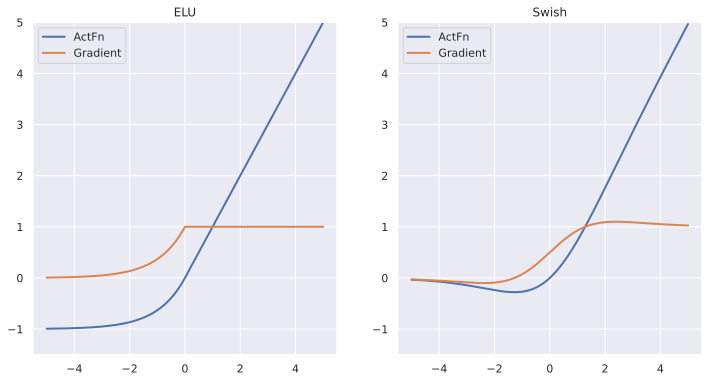

In [ ]:
# Plotting
cols = 2
rows = 1
fig, ax = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
for i, act_fn in enumerate(act_fns[4:]):
    vis_act_fn(act_fn, ax[i], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

### 3.Зачем нужны глубокие нейросети?

Большие модели требуют меньше данных для обучения (cм. левую картинку), [статья](https://arxiv.org/pdf/2001.08361)

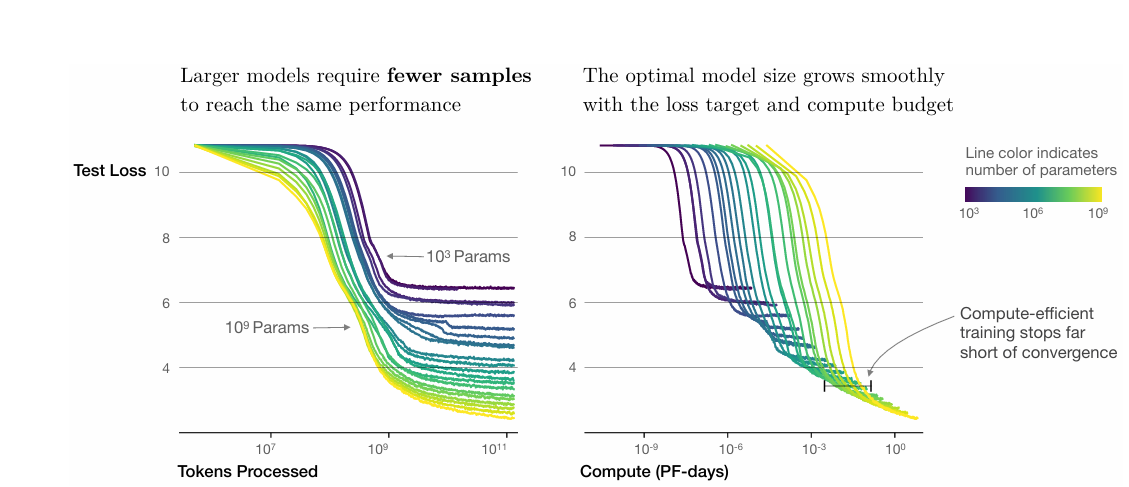

В какой-то момент при увеличении вычислений при обучении модели начинают резко улушать качество работы

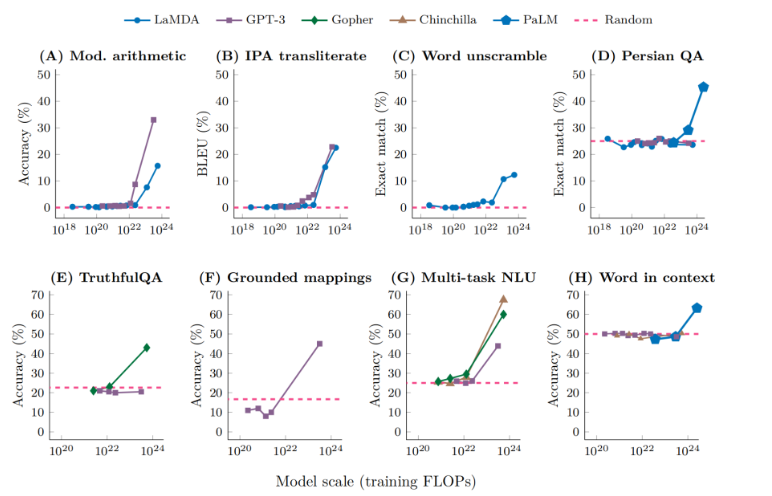

## 1.Слои нормализации

Какие проблемы возникают  при обучении нейронных сетей:


**1. Устранение дисбаланса масштабов признаков**
Проблема: Если признаки имеют разные диапазоны (например, возраст: 0–100, доход: 0–1 000 000), градиенты по параметрам сети будут неравномерными. Признаки с большими значениями могут доминировать, искажая процесс обучения.


**2. Ускорение сходимости обучения**
Градиентные методы (SGD, Adam) быстрее находят оптимум, когда поверхность функции потерь более "сглажена". Без нормализации оптимизатор совершает хаотичные шаги по одним измерениям и слишком мелкие — по другим.

Пример: Данные в диапазоне [−1, 1] позволяют использовать большие скорости обучения без риска расходимости.

**3. Борьба с внутренним ковариационным сдвигом (Internal Covariate Shift)**
Суть: Распределение входов слоёв меняется во время обучения из-за обновления параметров предыдущих слоёв. Это дестабилизирует обучение.

**4. Предотвращение насыщения активационных функций**
Функции вроде сигмоиды или гиперболического тангенса «насыщаются» при больших входных значениях, что приводит к исчезающим градиентам.

Решение: Batch Normalization (BN) нормализует активации каждого слоя по мини-батчам, стабилизируя среднее и дисперсию. Это позволяет использовать более высокие learning rates и упрощает инициализацию весов.


[Статья](https://arxiv.org/pdf/1502.03167) от Google 2015 года, где была описана ```batch normalization```.

### 1.1**Как работает Batch Normalization?**

1. **Вычисление статистики для мини-батча**  
   Для каждого признака (канала/нейрона) в активациях слоя вычисляются:  
   - **Среднее значение** по мини-батчу:  
     $$\mu = \frac{1}{m} \sum_{i=1}^m x_i$$  
   - **Дисперсия** по мини-батчу:  
     $$\sigma^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu)^2$$  
     где \(m\) — размер мини-батча, \(x_i\) — активации из батча.

2. **Нормализация**  
   Каждое значение в батче преобразуется к нулевому среднему и единичной дисперсии:  
   $$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$$  
   Здесь:  
   - $\epsilon$ — малое число (например, \(10^{-5}\)), чтобы избежать деления на ноль.  
   - Корень из дисперсии $\sqrt{\sigma^2 + \epsilon}$ называется **стандартным отклонением**.

3. **Масштабирование и сдвиг**  
   Вводятся два **обучаемых параметра**:  
   - $\gamma$ (масштаб) — регулирует "ширину" распределения.  
   - $\beta$ (сдвиг) — регулирует смещение распределения.  
   Итоговый выход слоя:  
   $$y_i = \gamma \cdot \hat{x}_i + \beta$$  
   Это позволяет сети:  
   - Сохранить выразительность (если нормализация не нужна, $\gamma = \sqrt{\sigma^2}$, $\beta = \mu$).  
   - Адаптировать распределение под задачу.

---

#### **Пример вычислений**  
Допустим, мини-батч состоит из 4 примеров, и для нейрона получены активации:  
`[2.0, 4.0, 6.0, 8.0]`  
1. $\mu = \frac{2 + 4 + 6 + 8}{4} = 5.0$  
2. $\sigma^2 = \frac{(2-5)^2 + (4-5)^2 + (6-5)^2 + (8-5)^2}{4} = 5.0$
3. $\hat{x}_i = \frac{x_i - 5}{\sqrt{5 + 1e-5}} \approx \frac{x_i - 5}{2.236}$  
   После нормализации: `[-1.342, -0.447, 0.447, 1.342]`  
4. Если $\gamma = 1.5\), \(\beta = 0.1\$, итоговые значения:  
   `[-1.342*1.5 + 0.1, ..., 1.342*1.5 + 0.1] ≈ [-1.913, -0.570, 0.770, 2.113]`.

#### <font color='DarkOrange'>**Вопрос (?)**</font> Что такое батч?

##### **Что такое батч (batch)?**  
**Батч** (или **мини-батч**) — это подмножество данных из общего набора, которое обрабатывается нейронной сетью **за один шаг обучения**. Например, если в датасете 10 000 изображений, а размер батча — 100, то за одну эпоху сеть обработает все данные за 100 шагов (10 000 / 100 = 100 итераций).

---

#### **Зачем нужны батчи?**
1. **Эффективность памяти**  
   Обработка всего датасета за раз (batch size = весь датасет) требует огромных вычислительных ресурсов. Мини-батчи позволяют обучать модель даже на слабом железе.

2. **Скорость обучения**  
   Обновление весов после каждого батча (а не после всей эпохи) ускоряет сходимость.  
   *Пример:* Стохастический градиентный спуск (SGD) использует батчи для приближённого расчёта градиента.

3. **Регуляризация**  
   Шум, возникающий из-за случайности выбора батчей, помогает избежать переобучения.

4. **Совместимость с методами вроде Batch Normalization**  
   Нормализация активаций требует статистики по батчу (среднее, дисперсия).

---

#### **Типы обучения по батчам**
- **Полный батч (Batch Gradient Descent):**  
  Размер батча = весь датасет.  
  Плюсы: точные градиенты.  
  Минусы: медленно, требует много памяти.

- **Стохастический (Stochastic Gradient Descent):**  
  Размер батча = 1 (каждый пример обрабатывается отдельно).  
  Плюсы: быстрая сходимость, подходит для онлайн-обучения.  
  Минусы: шумные обновления градиентов.

- **Мини-батч (Mini-batch Gradient Descent):**  
  Размер батча = N (обычно 32, 64, 128 и т.д.).  
  Золотая середина: баланс между стабильностью и скоростью.

---

#### **Как выбрать размер батча?**
- **Малый размер (32–128):**  
  Подходит для большинства задач, особенно при ограниченной памяти GPU.  
  Лучше для регуляризации, но требует больше итераций.

- **Большой размер (256–1024):**  
  Ускоряет обработку (оптимизация через матричные операции), но может ухудшить обобщение.  

- **Эмпирическое правило:**  
  Выбирайте максимальный размер, который "влезает" в память, не жертвуя качеством.

---

#### **Пример**  
- Датасет: 5000 изображений кошек и собак.  
- Batch size: 64.  
- Шагов за эпоху: 5000 / 64 ≈ 78 итераций.  
- На каждой итерации: сеть получает 64 изображения, вычисляет потерю, обновляет веса.


### 1.2 Как батч-нормализация влияет на обучение нейронных сетей?

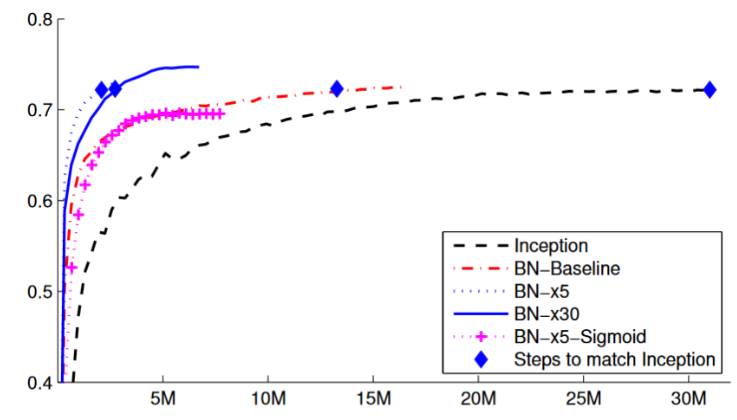

### 1.3 Как батч-нормализация работает при обучении и на тестировании

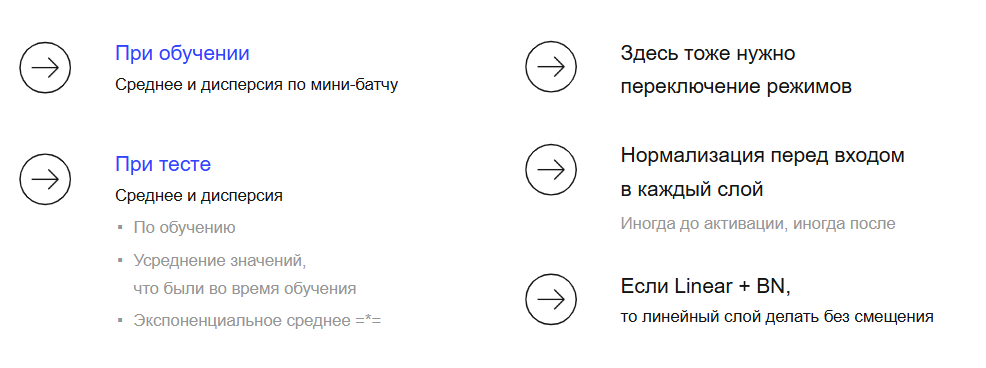

In [1]:
import torch
from torch import nn

In [4]:
bn1 = nn.BatchNorm1d (num_features=128,
                      eps=1e-05,
                      momentum=0.1,            # Определяет, как обновляются скользящие средние
                      affine=True,             # Включает обучаемые параметры масштаба \gamma и \beta
                      track_running_stats=True # Включает расчет скользящих средних
                      )

### 1.4 Другие варианты нормализации

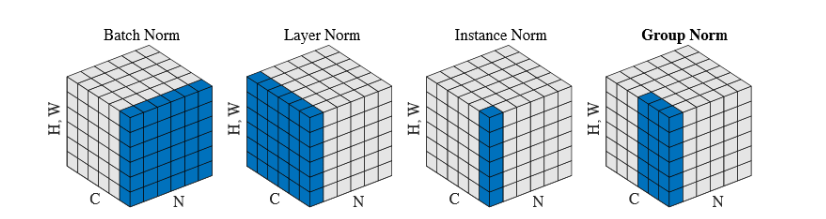

- Layer Normalization – Ba, Kiros, and Hinton, «Layer Normalization», arXiv 2016
- Instance Normalization – Ulyanov et al «Improved Texture Networks: Maximizing Quality and Diversity in Feed-forward Stylization and Texture Synthesis», CVPR 2017
- Group Normalization – Wu and He, «Group Normalization» arXiv 2018

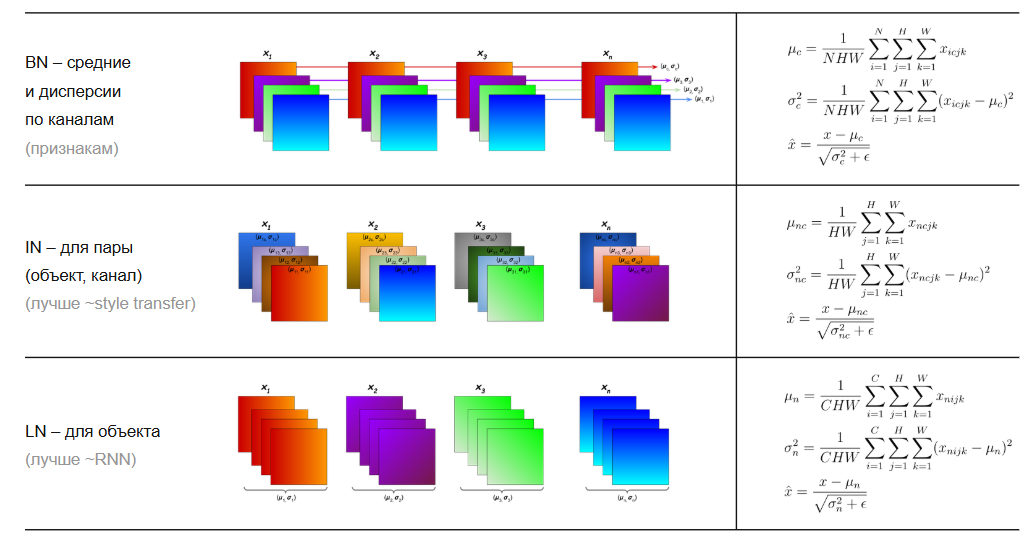

#### <font color='DarkOrange'>**Вопрос (?)**</font> Почему Layer Norm больше подходит для нейросетей для текстовых данных (RNN)?

### 1.5 Кастомная реализация batch-norm

In [5]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        # prediction mode - directly use the mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # fully-connected layer => calculate the mean and variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # two-dimensional convolutional layer => mean and variance on axis=1 (channel)
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # `num_features`: # outputs for a fully-connected layer or # output channels for a convolutional layer.
    # `num_dims`: 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # copy `moving_mean` and `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean,
                                                          self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 2.Слой dropout

### **Слой Dropout**  
**Dropout** — это метод регуляризации, используемый в нейронных сетях для предотвращения переобучения. Он работает путем случайного "отключения" (обнуления) части нейронов во время обучения, заставляя сеть учиться более устойчивым и обобщающим признакам.

---

### **Как работает Dropout?**  
1. **На этапе обучения:**  
   - Для каждого нейрона в слое с вероятностью `p` (гиперпараметр) его выходное значение обнуляется.  
   - Например, если `p = 0.5`, каждый нейрон имеет 50% шанс быть временно удалённым на текущем шаге обучения.  
   - Оставшиеся активные нейроны масштабируются на коэффициент `1 / (1 - p)`, чтобы сохранить мат. ожидание суммы входов следующего слоя.

2. **На этапе тестирования/инференса:**  
   - Все нейроны остаются активными.  
   - Веса сети масштабируются на `(1 - p)`, чтобы компенсировать отсутствие dropout.  
   *Пример:* Если `p = 0.2`, выходы слоя умножаются на `0.8`.

---

### **Зачем нужен Dropout?**  
1. **Борьба с переобучением (overfitting):**  
   - Случайное отключение нейронов предотвращает чрезмерную адаптацию сети к шумам в тренировочных данных.  
   - Сеть вынуждена распределять "знания" между всеми нейронами, а не запоминать данные через отдельные узлы.

2. **Эффект ансамбля моделей:**  
   На каждом шаге обучения активируется случайное подмножество нейронов, что эквивалентно обучению множества "подсетей" (ансамбля), которые затем усредняются.

3. **Уменьшение коадаптации нейронов:**  
   Нейроны учатся работать независимо, а не полагаться на конкретные связи.

---

### **Гиперпараметр `p`**  
- **`p`** — вероятность отключения нейрона (обычно `0.2 ≤ p ≤ 0.5`).  
  - Для входных слоев: `p = 0.1–0.2`.  
  - Для скрытых слоев: `p = 0.5`.  
- Слишком большое `p` может привести к недообучению, слишком маленькое — к слабой регуляризации.

---

### **Пример реализации в PyTorch**  
```python
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Отключает 50% нейронов
    nn.Linear(256, 10)
)
```

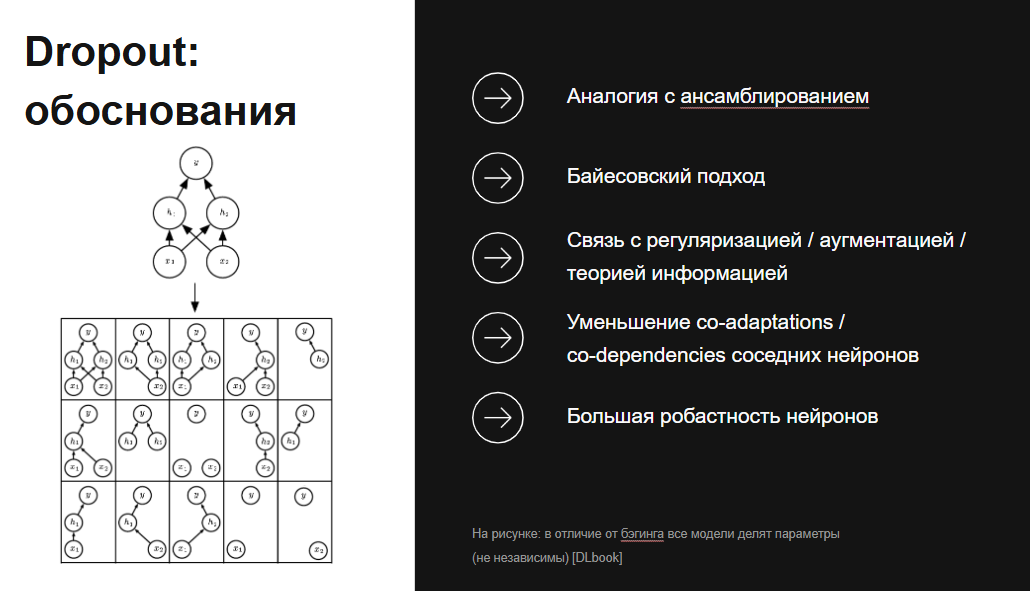

In [6]:
import torch.nn as nn

# Создание слоя Dropout с вероятностью отключения нейронов 30%
dropout_layer = nn.Dropout(p=0.3,        # Вероятность отключения (обнуления) каждого нейрона в слое на текущем шаге обучения.
                           inplace=False # Модифицирует входной тензор напрямую (экономит память)
                           )

#### <font color='DarkOrange'>**Вопрос (?)**</font> На что из линейных моделей похож `dropout`?

## 3.Инициализация весов
Правильную инициализацию весов pytorch делает **за нас!**

Этот раздел нужен для понимая основных правил инициализации весов нейронных сетей.

### 3.1 Основные идеи при инициализации весов нейронных сетей

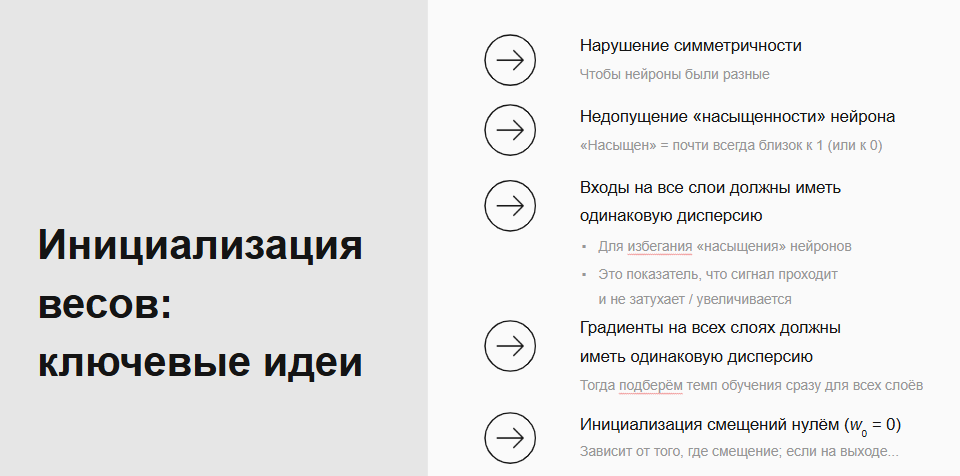

### 3.2 Как это выглядит в коде

In [15]:
m = nn.Linear(20, 30)
# 1. Kaiming (He) инициализация:
init.kaiming_normal_(m.weight, mode='fan_in',
                     nonlinearity='relu')

# 2. Xavier (Glorot) инициализация:
init.xavier_normal_(m.weight,
                    gain=nn.init.calculate_gain('tanh'))

# 3. Нулевая инициализация смещений:
init.constant_(m.bias, 0)


Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], requires_grad=True)

**Важные нюансы**
1. Всегда инициализируйте веса и смещения отдельно

2. Для BatchNorm:

- Веса (γ) инициализируйте в 1

- Смещения (β) в 0

Для выходного слоя иногда используют:
```python
init.normal_(m.weight, mean=0, std=0.01)
init.constant_(m.bias, 0)

```

## 4.Собираем итоговую многослойную сеть

### 4.1 Было

In [20]:
import torch
from torchsummary import summary

In [29]:
# определяем девайс на котором будем создавать нашу нейронную сеть
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [21]:
class Feedforward(torch.nn.Module):
    """
    Простая полносвязная нейронная сеть (feedforward).

    Args:
        input_size (int): Размерность входного вектора.
        hidden_size (int): Размерность скрытого слоя.
    """
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()

        # Запоминаем размеры входного и скрытого слоев
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Первый полносвязный (линейный) слой
        # input_size -> hidden_size  без bias
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size,
                                   bias=True)

        # Функция активации ReLU
        self.relu = torch.nn.ReLU()

        # Второй полносвязный (линейный) слой
        # hidden_size -> 1  без bias
        self.fc2 = torch.nn.Linear(self.hidden_size, 1,
                                   bias=True)

        # Функция активации Sigmoid (для выходного слоя, подходит для бинарной классификации)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x):
        """
        Прямой проход данных через сеть.

        Args:
            x (torch.Tensor): Входной тензор.

        Returns:
            torch.Tensor: Выходной тензор.
        """
        # Вычисляем выход первого слоя
        hidden = self.fc1(x)

        # Применяем ReLU к выходу первого слоя
        relu = self.relu(hidden)

        # Вычисляем выход второго слоя
        output = self.fc2(relu)

        # Применяем Sigmoid к выходу второго слоя
        output = self.sigmoid(output)

        return output

In [31]:
net = Feedforward(2, 3).to(device=device)
x = torch.tensor([1., 2.]).to(device=device)
net(x)

tensor([0.6074], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [33]:
summary(net, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
              ReLU-2                    [-1, 3]               0
            Linear-3                    [-1, 1]               4
           Sigmoid-4                    [-1, 1]               0
Total params: 13
Trainable params: 13
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### 4.2 Стало

In [50]:
import torch
import torch.nn as nn
import torch.nn.init as init

class AdvancedFeedforward(nn.Module):
    """
    Улучшенная полносвязная нейронная сеть с:
    - Инициализацией весов
    - Батч-нормализацией
    - Dropout

    Args:
        input_size (int): Размерность входного вектора
        hidden_size (int): Размерность скрытого слоя
        dropout_prob (float): Вероятность дропаута (по умолчанию 0.5)
    """
    def __init__(self, input_size, hidden_size, dropout_prob=0.5):
        super(AdvancedFeedforward, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # Первый полносвязный слой
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Батч-нормализация после первого слоя
        self.bn1 = nn.BatchNorm1d(hidden_size,
                                  affine=True,
                                  track_running_stats=True)

        # ReLU активация
        self.relu = nn.ReLU()

        # Dropout слой
        self.dropout = nn.Dropout(p=dropout_prob)

        # Второй полносвязный слой
        self.fc2 = nn.Linear(hidden_size, 1)

        # Сигмоида для выходного слоя
        self.sigmoid = nn.Sigmoid()

        # Инициализация весов
        self._initialize_weights()

    def _initialize_weights(self):
        """Кастомная инициализация весов"""
        # Инициализация Kaiming для линейных слоев
        init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')

        # Инициализация смещений нулями
        init.constant_(self.fc1.bias, 0)
        init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        # Первый слой -> батч-норма -> активация -> дропаут
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Второй слой -> сигмоида
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [51]:
net = AdvancedFeedforward(2, 3, 0.3).to(device=device)
x = torch.tensor([
                [1., 2.],
                [2., 3.]
                ]).to(device=device)
net(x)

tensor([[0.1822],
        [0.5000]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [52]:
summary(net, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
       BatchNorm1d-2                    [-1, 3]               6
              ReLU-3                    [-1, 3]               0
           Dropout-4                    [-1, 3]               0
            Linear-5                    [-1, 1]               4
           Sigmoid-6                    [-1, 1]               0
Total params: 19
Trainable params: 19
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


#### <font color='DarkOrange'>**Вопрос (?)**</font> Почему у batch norm 6 параметров?